In [7]:
import sys
sys.path.append('lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings

%reload_ext autoreload
%autoreload 2

In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, -1, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, -1, :, :, :].to(device)
test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


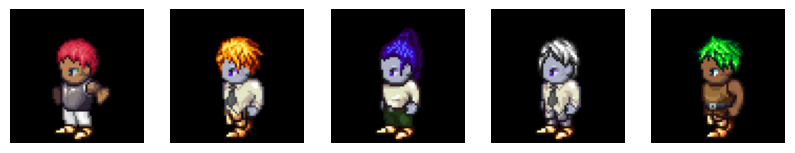

In [4]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [5]:
input_dim = (3, 64, 64)
f = 8 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='my_model',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 5, "factor": 0.5})


Latent dim: 192


In [6]:
device = 'cuda'
vae = VAE.load_from_folder('my_model/VAE_training_2024-05-22_14-43-10/final_model').to(device)
# out = vae(train_dataset[:-1].to(device))
# print(out.reconstruction_loss)
# print(out.reg_loss)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)


mu = []
log_var = []
with torch.no_grad():
    for _ , x in enumerate(train_loader):

        data = x.data

        out = vae.encoder(data.to(device))

        mu_data, log_var_data = out.embedding, out.log_covariance

        mu.append(mu_data)
        log_var.append(log_var_data)

mu = torch.cat(mu)
log_var = torch.cat(log_var)

In [8]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

In [10]:
########
in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 2
attention_levels = [2]
channel_multipliers = (1, 2, 4)
n_heads = 2

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

z = vae.to('cpu').encoder(train_dataset[0].data).embedding.view(1, 3, 64//f, 64//f)
empty_prompt_embed = None
unet(z, torch.tensor([10]), empty_prompt_embed).shape

torch.Size([1, 3, 8, 8])